# Bibliothèques et fonctions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
#import scikitplot as skplt
import gensim


from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import RegexpTokenizer

import scikitplot as skplt
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import itertools

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

# import transformers
# from torch.utils.data import Dataset, DataLoader
# from transformers import DistilBertModel, DistilBertTokenizer

In [236]:
# metrics
def get_metrics(y_test, y_predicted, global_c=False):

    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted' if global_c else None)             
    
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted' if global_c else None)
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted' if global_c else None)
    

    return accuracy, precision, recall, f1

# plotting
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

    return plt


# data proc



def process_data(X_train,y_train,strategy):

    if strategy == 'oversampling':

      oversample = RandomOverSampler(sampling_strategy='auto')
      X_train_over, y_train_over = oversample.fit_resample(X_train,y_train)

      return X_train_over, y_train_over

    elif strategy == 'undersampling':

      undersample = RandomUnderSampler(sampling_strategy='auto')
      # fit and apply the transform
      X_train_under, y_train_under = undersample.fit_resample(X_train,y_train)

      return X_train_under, y_train_under
  
  
    
    
# opt

def opt_procedure(model_object,X_train,y_train,X_test,y_test,classes_):


  model = model_object

  # Initial Model Fit with stock hyper_params

  model.fit(X_train,y_train)

  y_predict = model.predict(X_test)
  y_proba = model.predict_proba(X_test)

  #global metrics
  print('*'*3 +  ' Global Metrics ' + '*'*3)
  accuracy, precision, recall, f1 = get_metrics(y_test, y_predict,global_c=True)
  print('accuracy = {} \n precision = {} \n recall = {} \n f1 = {}'.format(accuracy, precision, recall, f1))

  #global metrics
  print('*'*3 +  ' Per Class Metrics ' + '*'*3)
  accuracy, precision, recall, f1 = get_metrics(y_test, y_predict,global_c=False)
  print('accuracy = {} \n precision = {} \n recall = {} \n f1 = {}'.format(accuracy, precision, recall, f1))

  # confusion matrix
  cm = confusion_matrix(y_test, y_predict)
  fig = plt.figure(figsize=(10, 10))
  plot = plot_confusion_matrix(cm, classes = classes_, normalize=True, title='Confusion matrix')
  plt.show()

  # ROC curves
  skplt.metrics.plot_roc(y_test, y_proba)
  plt.show()

  return model




class hyper_model:
    
    def __init__(self,model_name,X_train,y_train,X_test,y_test,classes=[0,1]):
        
      self.model_name = model_name
      self.X_train = X_train
      self.y_train = y_train
      self.X_test = X_test
      self.y_test = y_test
      self.classes = classes
      #self.cv_fold = cv_fold
      self.model = None

    def fit(self):

      #cv = KFold(n_splits=self.cv_fold, shuffle=True, random_state=42)  

         
      # Logistic Regression

      if self.model_name == 'logistic_class':

        md = LogisticRegressionCV( class_weight='balanced',multi_class ='multinomial', solver='newton-cg',
                                  verbose=2,random_state=42,n_jobs=-1)

        self.model = opt_procedure(classes_ = self.classes, model_object=md,X_train=self.X_train,y_train=self.y_train,
          X_test=self.X_test,y_test=self.y_test)

      # Random Forest

      if self.model_name == 'random_forest_class':

        md = RandomForestClassifier(class_weight='balanced_subsample', verbose=2,random_state=42,n_jobs=-1, n_estimators=10000)

        self.model = opt_procedure(classes_ = self.classes, model_object=md,X_train=self.X_train,y_train=self.y_train,
          X_test=self.X_test,y_test=self.y_test)


      if self.model_name == 'gaussian_class':
        md = GaussianProcessClassifier()

        self.model = opt_procedure(classes_ = self.classes, model_object=md,X_train=self.X_train,y_train=self.y_train,
          X_test=self.X_test,y_test=self.y_test)

      if self.model_name == 'adaboost_class':
        md = AdaBoostClassifier(n_estimators=1000)

        self.model = opt_procedure(classes_ = self.classes, model_object=md,X_train=self.X_train,y_train=self.y_train,
          X_test=self.X_test,y_test=self.y_test)
      if self.model_name == 'mlp_class':
        md = MLPClassifier()

        self.model = opt_procedure(classes_ = self.classes, model_object=md,X_train=self.X_train,y_train=self.y_train,
          X_test=self.X_test,y_test=self.y_test)



         



In [354]:
def clean_uppercase(text) :
    return str(text).lower()

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

def clean_tokenization(text):
    return word_tokenize(text)

def token_to_text(token) :
    return ' '.join(token)

def clean_stemmatization(token):
    return [stemmer.stem(w) for w in token]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wawa_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:

# embeddings



 # wv

word2vec_path = "GoogleNews-vectors-negative300.bin.gz" #download this file online and put in on your notebook folder
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

tokenizer = RegexpTokenizer(r'\w+')


def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions_tokens, generate_missing=False):
    embeddings = clean_questions_tokens.apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

# Critère : Renouvellement

In [151]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')

In [152]:
df.columns
metric = 'Renewal of an older telework agreement\n(0=NO, 1=YES)'
df[metric].unique()
df.loc[df[metric].isnull(),metric]=0

df_0 = df
df = df[['contenu',metric]]
df = df.dropna()
def crop_content(content) :
    n = min(5_000,len(content))
    return content[:n]
df['contenu']= df['contenu'].apply(crop_content)

In [153]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [154]:
features = pd.DataFrame(embeddings_desc)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [157]:
X_train_under, y_train_under = process_data(X_train,y_train,strategy='undersampling')

In [158]:
y_train_under.value_counts()

0    806
1    806
Name: Renewal of an older telework agreement\n(0=NO, 1=YES), dtype: int64

In [159]:
random_forest_class = hyper_model(model_name = 'random_forest_class',
                        X_train = X_train_under,
                        y_train = y_train_under,
                        X_test = X_test,
                        y_test = y_test,
                        classes=[0,1])  

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.0s


building tree 1 of 10000building tree 2 of 10000
building tree 3 of 10000
building tree 4 of 10000

building tree 5 of 10000building tree 6 of 10000

building tree 7 of 10000
building tree 8 of 10000
building tree 9 of 10000building tree 10 of 10000

building tree 11 of 10000
building tree 12 of 10000
building tree 13 of 10000
building tree 14 of 10000building tree 15 of 10000building tree 16 of 10000

building tree 17 of 10000

building tree 18 of 10000
building tree 19 of 10000building tree 20 of 10000

building tree 21 of 10000
building tree 22 of 10000
building tree 23 of 10000building tree 24 of 10000
building tree 25 of 10000

building tree 26 of 10000
building tree 27 of 10000building tree 28 of 10000

building tree 29 of 10000
building tree 30 of 10000building tree 31 of 10000

building tree 32 of 10000
building tree 33 of 10000
building tree 34 of 10000building tree 35 of 10000

building tree 36 of 10000
building tree 37 of 10000building tree 38 of 10000
building tree 39 of 10

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    0.3s



building tree 223 of 10000building tree 224 of 10000

building tree 225 of 10000
building tree 226 of 10000
building tree 227 of 10000building tree 228 of 10000

building tree 229 of 10000building tree 230 of 10000

building tree 231 of 10000
building tree 232 of 10000
building tree 233 of 10000
building tree 234 of 10000
building tree 235 of 10000
building tree 236 of 10000
building tree 237 of 10000
building tree 238 of 10000
building tree 239 of 10000
building tree 240 of 10000
building tree 241 of 10000
building tree 242 of 10000building tree 243 of 10000
building tree 244 of 10000

building tree 245 of 10000
building tree 246 of 10000
building tree 247 of 10000
building tree 248 of 10000
building tree 249 of 10000
building tree 250 of 10000
building tree 251 of 10000
building tree 252 of 10000
building tree 253 of 10000
building tree 254 of 10000
building tree 255 of 10000
building tree 256 of 10000building tree 257 of 10000

building tree 258 of 10000
building tree 259 of 10000


[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    0.8s


building tree 391 of 10000
building tree 392 of 10000
building tree 393 of 10000
building tree 394 of 10000building tree 395 of 10000
building tree 396 of 10000building tree 397 of 10000


building tree 398 of 10000
building tree 399 of 10000
building tree 400 of 10000
building tree 401 of 10000
building tree 402 of 10000
building tree 403 of 10000
building tree 404 of 10000building tree 405 of 10000
building tree 406 of 10000
building tree 407 of 10000
building tree 408 of 10000

building tree 409 of 10000
building tree 410 of 10000building tree 411 of 10000

building tree 412 of 10000building tree 413 of 10000

building tree 414 of 10000
building tree 415 of 10000
building tree 416 of 10000
building tree 417 of 10000
building tree 418 of 10000
building tree 419 of 10000building tree 420 of 10000building tree 421 of 10000


building tree 422 of 10000
building tree 423 of 10000building tree 424 of 10000
building tree 425 of 10000

building tree 426 of 10000
building tree 427 of 10000
b

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    1.4s


building tree 711 of 10000
building tree 712 of 10000
building tree 713 of 10000
building tree 714 of 10000
building tree 715 of 10000
building tree 716 of 10000
building tree 717 of 10000
building tree 718 of 10000building tree 719 of 10000

building tree 720 of 10000
building tree 721 of 10000building tree 722 of 10000

building tree 723 of 10000
building tree 724 of 10000
building tree 725 of 10000
building tree 726 of 10000
building tree 727 of 10000
building tree 728 of 10000building tree 729 of 10000

building tree 730 of 10000building tree 731 of 10000

building tree 732 of 10000
building tree 733 of 10000
building tree 734 of 10000
building tree 735 of 10000
building tree 736 of 10000
building tree 737 of 10000building tree 738 of 10000

building tree 739 of 10000
building tree 740 of 10000
building tree 741 of 10000
building tree 742 of 10000
building tree 743 of 10000
building tree 744 of 10000
building tree 745 of 10000building tree 746 of 10000

building tree 747 of 10000
b

[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:    2.3s


building tree 1037 of 10000
building tree 1038 of 10000

building tree 1039 of 10000
building tree 1040 of 10000building tree 1041 of 10000

building tree 1042 of 10000building tree 1043 of 10000
building tree 1044 of 10000building tree 1045 of 10000


building tree 1046 of 10000
building tree 1047 of 10000
building tree 1048 of 10000
building tree 1049 of 10000
building tree 1050 of 10000
building tree 1051 of 10000
building tree 1052 of 10000
building tree 1053 of 10000
building tree 1054 of 10000
building tree 1055 of 10000
building tree 1056 of 10000
building tree 1057 of 10000building tree 1058 of 10000building tree 1059 of 10000


building tree 1060 of 10000
building tree 1061 of 10000
building tree 1062 of 10000
building tree 1063 of 10000
building tree 1064 of 10000
building tree 1065 of 10000building tree 1066 of 10000

building tree 1067 of 10000building tree 1068 of 10000

building tree 1069 of 10000building tree 1070 of 10000building tree 1071 of 10000


building tree 1072 

[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:    3.3s



building tree 1529 of 10000building tree 1530 of 10000

building tree 1531 of 10000
building tree 1532 of 10000building tree 1533 of 10000

building tree 1534 of 10000building tree 1535 of 10000

building tree 1536 of 10000
building tree 1537 of 10000
building tree 1538 of 10000
building tree 1539 of 10000
building tree 1540 of 10000
building tree 1541 of 10000
building tree 1542 of 10000
building tree 1543 of 10000
building tree 1544 of 10000
building tree 1545 of 10000
building tree 1546 of 10000building tree 1547 of 10000
building tree 1548 of 10000

building tree 1549 of 10000
building tree 1550 of 10000
building tree 1551 of 10000building tree 1552 of 10000

building tree 1553 of 10000
building tree 1554 of 10000building tree 1555 of 10000

building tree 1556 of 10000
building tree 1557 of 10000
building tree 1558 of 10000
building tree 1559 of 10000
building tree 1560 of 10000
building tree 1561 of 10000
building tree 1562 of 10000
building tree 1563 of 10000
building tree 1564 

[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:    4.4s


building tree 2035 of 10000building tree 2036 of 10000

building tree 2037 of 10000
building tree 2038 of 10000building tree 2039 of 10000

building tree 2040 of 10000
building tree 2041 of 10000building tree 2042 of 10000

building tree 2043 of 10000
building tree 2044 of 10000
building tree 2045 of 10000
building tree 2046 of 10000building tree 2047 of 10000

building tree 2048 of 10000
building tree 2049 of 10000
building tree 2050 of 10000
building tree 2051 of 10000building tree 2052 of 10000

building tree 2053 of 10000
building tree 2054 of 10000
building tree 2055 of 10000building tree 2056 of 10000

building tree 2057 of 10000
building tree 2058 of 10000
building tree 2059 of 10000
building tree 2060 of 10000building tree 2061 of 10000
building tree 2062 of 10000building tree 2063 of 10000


building tree 2064 of 10000
building tree 2065 of 10000
building tree 2066 of 10000
building tree 2067 of 10000building tree 2068 of 10000

building tree 2069 of 10000
building tree 2070 o

[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:    5.8s


building tree 2629 of 10000
building tree 2630 of 10000
building tree 2631 of 10000
building tree 2632 of 10000
building tree 2633 of 10000
building tree 2634 of 10000
building tree 2635 of 10000building tree 2636 of 10000

building tree 2637 of 10000
building tree 2638 of 10000building tree 2639 of 10000

building tree 2640 of 10000
building tree 2641 of 10000building tree 2642 of 10000
building tree 2643 of 10000

building tree 2644 of 10000building tree 2645 of 10000

building tree 2646 of 10000
building tree 2647 of 10000
building tree 2648 of 10000
building tree 2649 of 10000
building tree 2650 of 10000
building tree 2651 of 10000
building tree 2652 of 10000
building tree 2653 of 10000building tree 2654 of 10000

building tree 2655 of 10000building tree 2656 of 10000

building tree 2657 of 10000
building tree 2658 of 10000
building tree 2659 of 10000building tree 2660 of 10000

building tree 2661 of 10000
building tree 2662 of 10000
building tree 2663 of 10000
building tree 2664 o

[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:    7.2s



building tree 3349 of 10000
building tree 3350 of 10000
building tree 3351 of 10000
building tree 3352 of 10000
building tree 3353 of 10000building tree 3354 of 10000
building tree 3355 of 10000
building tree 3356 of 10000
building tree 3357 of 10000
building tree 3358 of 10000

building tree 3359 of 10000
building tree 3360 of 10000
building tree 3361 of 10000
building tree 3362 of 10000
building tree 3363 of 10000
building tree 3364 of 10000
building tree 3365 of 10000
building tree 3366 of 10000building tree 3367 of 10000building tree 3368 of 10000


building tree 3369 of 10000
building tree 3370 of 10000
building tree 3371 of 10000building tree 3372 of 10000

building tree 3373 of 10000
building tree 3374 of 10000
building tree 3375 of 10000
building tree 3376 of 10000
building tree 3377 of 10000
building tree 3378 of 10000
building tree 3379 of 10000
building tree 3380 of 10000building tree 3381 of 10000
building tree 3382 of 10000

building tree 3383 of 10000
building tree 3384 

[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:    8.9s



building tree 4041 of 10000
building tree 4042 of 10000
building tree 4043 of 10000
building tree 4044 of 10000
building tree 4045 of 10000
building tree 4046 of 10000
building tree 4047 of 10000
building tree 4048 of 10000building tree 4049 of 10000

building tree 4050 of 10000
building tree 4051 of 10000
building tree 4052 of 10000
building tree 4053 of 10000
building tree 4054 of 10000
building tree 4055 of 10000building tree 4056 of 10000

building tree 4057 of 10000
building tree 4058 of 10000
building tree 4059 of 10000
building tree 4060 of 10000
building tree 4061 of 10000building tree 4062 of 10000building tree 4063 of 10000


building tree 4064 of 10000
building tree 4065 of 10000building tree 4066 of 10000

building tree 4067 of 10000
building tree 4068 of 10000building tree 4069 of 10000
building tree 4070 of 10000
building tree 4071 of 10000

building tree 4072 of 10000
building tree 4073 of 10000
building tree 4074 of 10000
building tree 4075 of 10000building tree 4076 o

[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:   10.7s



building tree 4916 of 10000
building tree 4917 of 10000
building tree 4918 of 10000
building tree 4919 of 10000building tree 4920 of 10000

building tree 4921 of 10000building tree 4922 of 10000

building tree 4923 of 10000
building tree 4924 of 10000
building tree 4925 of 10000
building tree 4926 of 10000
building tree 4927 of 10000
building tree 4928 of 10000
building tree 4929 of 10000
building tree 4930 of 10000
building tree 4931 of 10000
building tree 4932 of 10000
building tree 4933 of 10000building tree 4934 of 10000

building tree 4935 of 10000building tree 4936 of 10000

building tree 4937 of 10000
building tree 4938 of 10000
building tree 4939 of 10000
building tree 4940 of 10000
building tree 4941 of 10000
building tree 4942 of 10000
building tree 4943 of 10000
building tree 4944 of 10000
building tree 4945 of 10000
building tree 4946 of 10000
building tree 4947 of 10000
building tree 4948 of 10000
building tree 4949 of 10000
building tree 4950 of 10000
building tree 4951 

[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:   12.7s


building tree 5903 of 10000

building tree 5904 of 10000building tree 5905 of 10000

building tree 5906 of 10000building tree 5907 of 10000

building tree 5908 of 10000
building tree 5909 of 10000
building tree 5910 of 10000
building tree 5911 of 10000
building tree 5912 of 10000
building tree 5913 of 10000building tree 5914 of 10000

building tree 5915 of 10000
building tree 5916 of 10000
building tree 5917 of 10000
building tree 5918 of 10000
building tree 5919 of 10000
building tree 5920 of 10000
building tree 5921 of 10000building tree 5922 of 10000

building tree 5923 of 10000
building tree 5924 of 10000
building tree 5925 of 10000
building tree 5926 of 10000building tree 5927 of 10000

building tree 5928 of 10000building tree 5929 of 10000

building tree 5930 of 10000
building tree 5931 of 10000building tree 5932 of 10000
building tree 5933 of 10000

building tree 5934 of 10000
building tree 5935 of 10000
building tree 5936 of 10000
building tree 5937 of 10000
building tree 5938 

[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:   14.9s


building tree 6834 of 10000
building tree 6835 of 10000
building tree 6836 of 10000
building tree 6837 of 10000building tree 6838 of 10000

building tree 6839 of 10000building tree 6840 of 10000

building tree 6841 of 10000
building tree 6842 of 10000
building tree 6843 of 10000
building tree 6844 of 10000
building tree 6845 of 10000
building tree 6846 of 10000
building tree 6847 of 10000
building tree 6848 of 10000
building tree 6849 of 10000building tree 6850 of 10000

building tree 6851 of 10000
building tree 6852 of 10000building tree 6853 of 10000
building tree 6854 of 10000

building tree 6855 of 10000
building tree 6856 of 10000
building tree 6857 of 10000
building tree 6858 of 10000
building tree 6859 of 10000
building tree 6860 of 10000
building tree 6861 of 10000
building tree 6862 of 10000
building tree 6863 of 10000
building tree 6864 of 10000
building tree 6865 of 10000building tree 6866 of 10000

building tree 6867 of 10000
building tree 6868 of 10000building tree 6869 of

[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:   17.2s



building tree 7984 of 10000
building tree 7985 of 10000
building tree 7986 of 10000building tree 7987 of 10000

building tree 7988 of 10000building tree 7989 of 10000building tree 7990 of 10000building tree 7991 of 10000

building tree 7992 of 10000building tree 7993 of 10000



building tree 7994 of 10000
building tree 7995 of 10000
building tree 7996 of 10000
building tree 7997 of 10000
building tree 7998 of 10000
building tree 7999 of 10000
building tree 8000 of 10000
building tree 8001 of 10000
building tree 8002 of 10000building tree 8003 of 10000

building tree 8004 of 10000
building tree 8005 of 10000
building tree 8006 of 10000
building tree 8007 of 10000
building tree 8008 of 10000
building tree 8009 of 10000
building tree 8010 of 10000
building tree 8011 of 10000
building tree 8012 of 10000
building tree 8013 of 10000
building tree 8014 of 10000
building tree 8015 of 10000
building tree 8016 of 10000building tree 8017 of 10000

building tree 8018 of 10000
building tree 8019 

[Parallel(n_jobs=-1)]: Done 9089 tasks      | elapsed:   19.8s



building tree 9105 of 10000

building tree 9106 of 10000
building tree 9107 of 10000
building tree 9108 of 10000
building tree 9109 of 10000
building tree 9110 of 10000
building tree 9111 of 10000
building tree 9112 of 10000
building tree 9113 of 10000building tree 9114 of 10000
building tree 9115 of 10000

building tree 9116 of 10000
building tree 9117 of 10000
building tree 9118 of 10000
building tree 9119 of 10000
building tree 9120 of 10000
building tree 9121 of 10000
building tree 9122 of 10000
building tree 9123 of 10000
building tree 9124 of 10000building tree 9125 of 10000

building tree 9126 of 10000
building tree 9127 of 10000
building tree 9128 of 10000
building tree 9129 of 10000
building tree 9130 of 10000
building tree 9131 of 10000
building tree 9132 of 10000building tree 9133 of 10000

building tree 9134 of 10000
building tree 9135 of 10000building tree 9136 of 10000

building tree 9137 of 10000
building tree 9138 of 10000
building tree 9139 of 10000
building tree 9140

[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   21.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 1961 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 3257 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 4877 tasks      | elapsed:    0.6s
[Parallel(n_jobs=12)]: Done 5808 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 6821 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 7

*** Global Metrics ***
accuracy = 0.6375 
 precision = 0.6863762175139957 
 recall = 0.6375 
 f1 = 0.6518746618126166
*** Per Class Metrics ***
accuracy = 0.6375 
 precision = [0.79768786 0.41929134] 
 recall = [0.65171192 0.60339943] 
 f1 = [0.71734893 0.49477352]


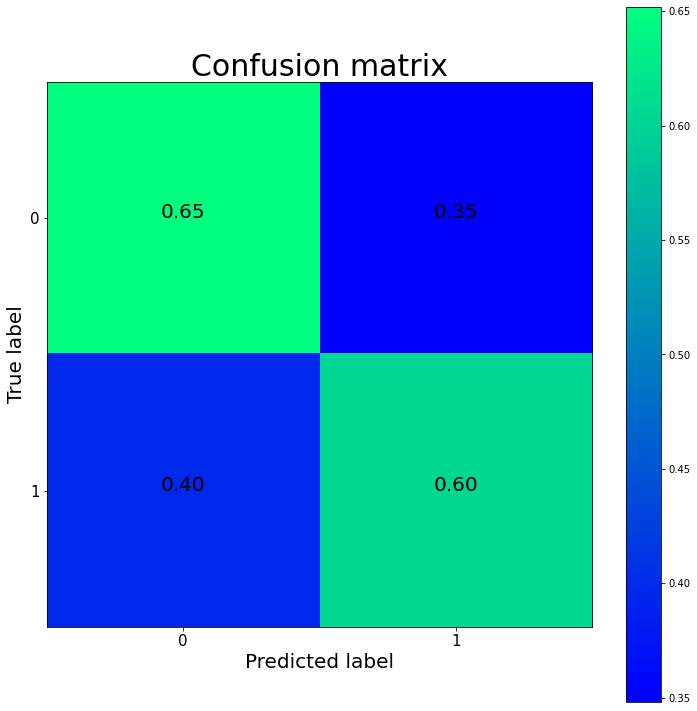

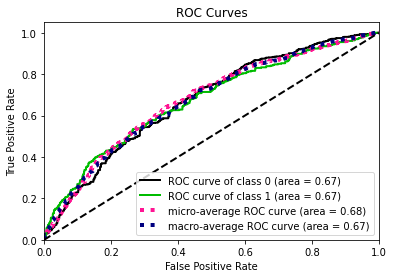

In [160]:
random_forest_class.fit()

# Critère : Droit déconnexion

## Première approche : Machine Learning

In [161]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')


In [162]:
df.columns
metric = 'Measures for the Right to Disconnect OR a reference to a Right to Disconnect agreement are planned\n (0=NO, 1=YES)'
df[metric].unique()
df.loc[df[metric].isnull(),metric]=0

df_0 = df
df = df[['contenu',metric]]
df = df.dropna()
# def crop_content(content) :
#     n = min(10_000,len(content))
#     return content[:n]
# df['contenu']= df['contenu'].apply(crop_content)

In [163]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [164]:
features = pd.DataFrame(embeddings_desc)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [167]:
adaboost_class = hyper_model(model_name = 'adaboost_class',
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test,
                        classes=[0,1])  

*** Global Metrics ***
accuracy = 0.6341666666666667 
 precision = 0.6345203643041907 
 recall = 0.6341666666666667 
 f1 = 0.6342691175615579
*** Per Class Metrics ***
accuracy = 0.6341666666666667 
 precision = [0.65024631 0.61759729] 
 recall = [0.63665595 0.63148789] 
 f1 = [0.64337937 0.62446536]


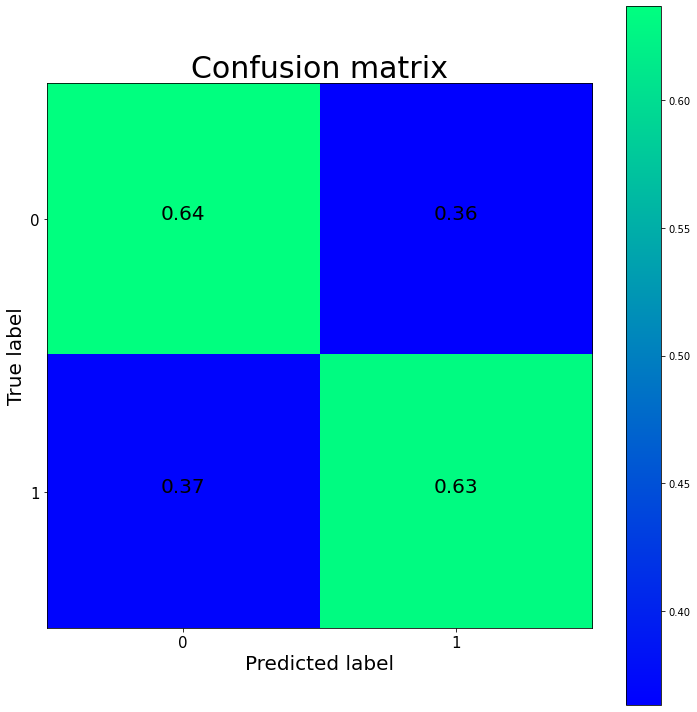

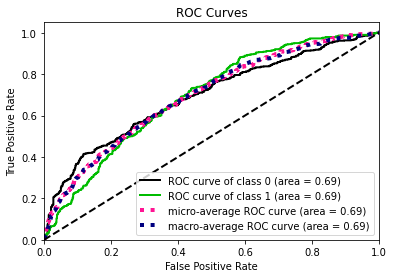

In [168]:
adaboost_class.fit()

## Seconde approche : Recherche par mots-clés

Cette seconde approche se révèle plus efficace pour ce critère-ci. 

In [355]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')


In [357]:
df['contenu']=df['contenu'].apply(clean_uppercase)
df['contenu']=df['contenu'].apply(clean_tokenization)
df['contenu']=df['contenu'].apply(clean_stemmatization)

In [360]:
true_negative = 0
false_negative = 0
true_positive = 0
false_positive = 0

metric = 'Measures for the Right to Disconnect OR a reference to a Right to Disconnect agreement are planned\n (0=NO, 1=YES)'

for i in range(len(df)):
    line = df.iloc[i]
    true_val = line[metric]
    agree = line['contenu']
    predi = 0 
    for j in range(len(agree)) :
        if agree[j] in ('déconnexion','deconnexion') :
            predi = 1

for i in range(len(df)):
    line = df.iloc[i]
    true_val = line[metric]
    agree = line['contenu']
    predi = 0 
    for j in range(len(agree)) :
        if agree[j]=='droit' :
            if agree[j+1] in ('a','à') :
                if agree[j+2]=='la' :
                    if agree[j+3] in ('déconnexion','deconnexion') :
                        predi = 1
    if predi == 0 :
        true_negative += (predi==true_val)
        false_negative += (predi!=true_val)
    if predi == 1 :
        true_positive += (predi==true_val)
        false_positive += (predi!=true_val)

In [364]:
print('Confusion matrix:\n','✔ True negative:',true_negative/(true_negative+false_positive), '      X False positive:',false_positive/(true_negative+false_positive), '\n','X False negative:',false_negative/(true_positive+false_negative),'    ✔ True Positive:',true_positive/(true_positive+false_negative))

Confusion matrix:
 ✔ True negative: 0.7450142450142451       X False positive: 0.254985754985755 
 X False negative: 0.15575501583949314     ✔ True Positive: 0.8442449841605069


# Critère : Couverture coûts

In [169]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')

In [170]:
df.columns
metric = 'Coverage of costs of telework (Internet subscription, electricity, heater, consumables) by the company                                 (0=NO, 1=YES)'
df[metric].unique()
df.loc[df[metric].isnull(),metric]=0

df_0 = df
df = df[['contenu',metric]]
df = df.dropna()
# def crop_content(content) :
#     n = min(10_000,len(content))
#     return content[:n]
# df['contenu']= df['contenu'].apply(crop_content)

In [171]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [172]:
features = pd.DataFrame(embeddings_desc)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [174]:
log_class = hyper_model(model_name = 'logistic_class',
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test,
                        classes=[0,1])  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    3.2s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.3s finished


*** Global Metrics ***
accuracy = 0.6541666666666667 
 precision = 0.6752613321128943 
 recall = 0.6541666666666667 
 f1 = 0.6599902878778166
*** Per Class Metrics ***
accuracy = 0.6541666666666667 
 precision = [0.76435045 0.51858736] 
 recall = [0.66143791 0.64137931] 
 f1 = [0.7091801  0.57348407]


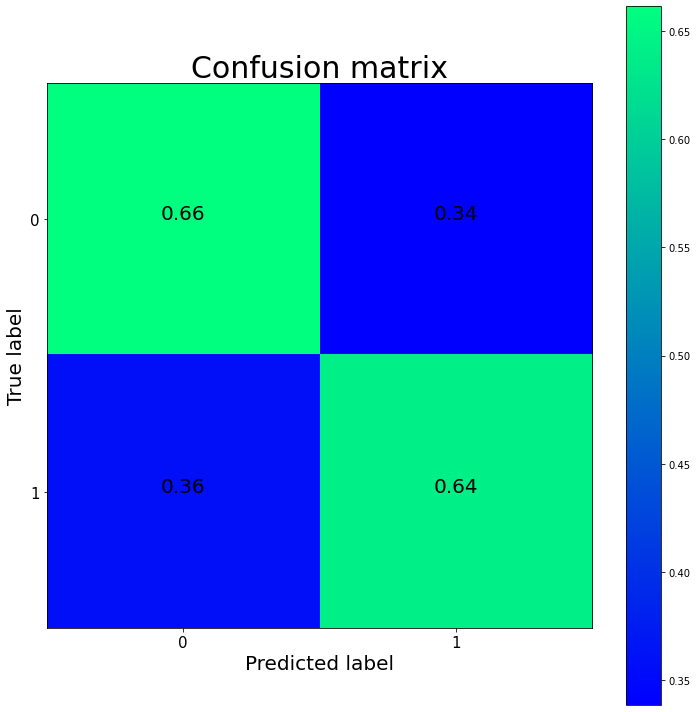

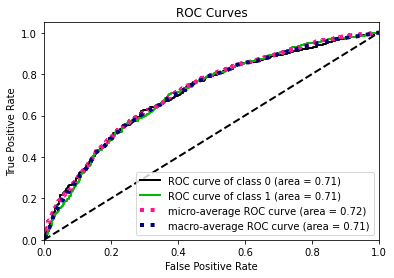

In [175]:
log_class.fit()

# Critère : Mêmes horaires qu'au bureau

In [176]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')


In [177]:
df.columns
metric = 'The employee is required to work the same schedule as in the office                                  (0=NO, 1=YES)'
df[metric].unique()
df.loc[df[metric].isnull(),metric]=0

df_0 = df
df = df[['contenu',metric]]
df = df.dropna()
# def crop_content(content) :
#     n = min(10_000,len(content))
#     return content[:n]
# df['contenu']= df['contenu'].apply(crop_content)

In [178]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [179]:
features = pd.DataFrame(embeddings_desc)

In [180]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [198]:
X_train_under, y_train_under = process_data(X_train,y_train,strategy='undersampling')

In [199]:
adaboost_class = hyper_model(model_name = 'adaboost_class',
                        X_train = X_train_under,
                        y_train = y_train_under,
                        X_test = X_test,
                        y_test = y_test,
                        classes=[0,1])  

*** Global Metrics ***
accuracy = 0.5783333333333334 
 precision = 0.5935988839980436 
 recall = 0.5783333333333334 
 f1 = 0.5811177501482151
*** Per Class Metrics ***
accuracy = 0.5783333333333334 
 precision = [0.66326531 0.49673203] 
 recall = [0.55873926 0.60557769] 
 f1 = [0.60653188 0.54578097]


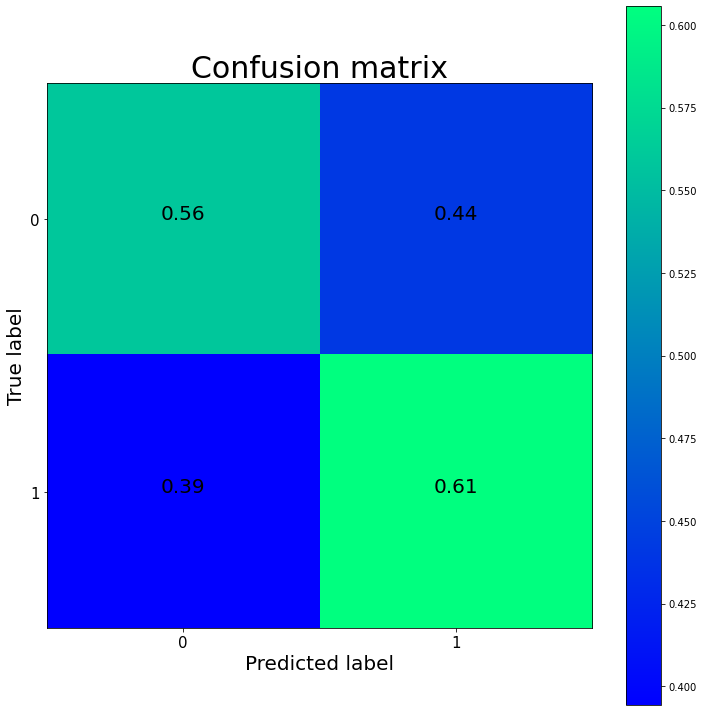

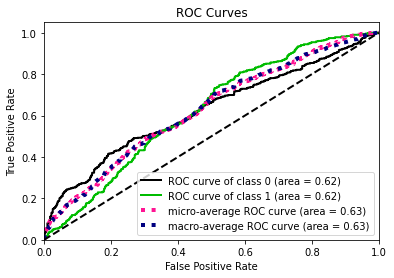

In [200]:
adaboost_class.fit()

# Critère : Temps de travail contrôlé

In [259]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')


In [260]:
df.columns
metric = 'Working time is controlled:                               Can be a declaration of worked hours by the employee, or can be a control made by the employer (for example the employee must log-in to a platform to monitor their presence,...)                                                       (0=NO, 1=YES)'
df[metric].unique()
df.loc[df[metric].isnull(),metric]=0

df_0 = df
df = df[['contenu',metric]]
df = df.dropna()
# def crop_content(content) :
#     n = min(10_000,len(content))
#     return content[:n]
# df['contenu']= df['contenu'].apply(crop_content)

In [261]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [262]:
features = pd.DataFrame(embeddings_desc)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [283]:
log_class = hyper_model(model_name = 'logistic_class',
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test,
                        classes=[0,1])  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


*** Global Metrics ***
accuracy = 0.5791666666666667 
 precision = 0.6190104166666667 
 recall = 0.5791666666666667 
 f1 = 0.5899930853787935
*** Per Class Metrics ***
accuracy = 0.5791666666666667 
 precision = [0.725  0.4125] 
 recall = [0.5851198  0.56756757] 
 f1 = [0.64759246 0.47776629]


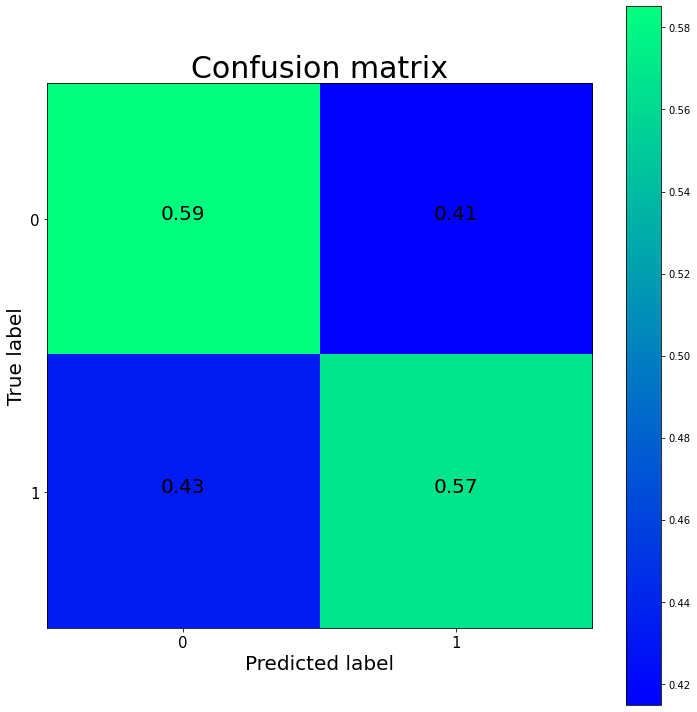

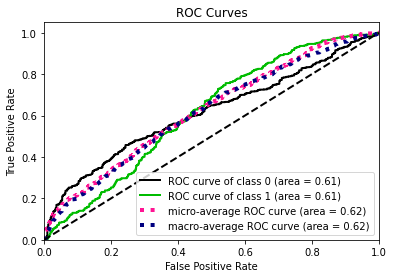

In [284]:
log_class.fit()

# Critère : Jours/sem

In [309]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')


In [310]:
df.columns
metric = 'Number of days of teleworking if specified by WEEK                                    (0, 1, 2, 3, 4, 5, 6 IF THE NUMBER OF DAYS IS PER WEEK ; ELSE NaN)'
df[metric].unique()
df.loc[df[metric].isnull(),metric]=0

df_0 = df
df = df[['contenu',metric]]
df = df.dropna()
# def crop_content(content) :
#     n = min(10_000,len(content))
#     return content[:n]
# df['contenu']= df['contenu'].apply(crop_content)

In [246]:
df.loc[df[metric]==0.5,metric]=1
df.loc[df[metric]==2.5,metric]=3
df.loc[df[metric]>2,metric]=2

In [247]:
df[metric]= df[metric].astype(int)

In [248]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [249]:
features = pd.DataFrame(embeddings_desc)

In [250]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [251]:
log_class = hyper_model(model_name = 'logistic_class',
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test,
                        classes=[0,1,2])  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.3s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


*** Global Metrics ***
accuracy = 0.5325 
 precision = 0.5512259362813343 
 recall = 0.5325 
 f1 = 0.5365577351441502
*** Per Class Metrics ***
accuracy = 0.5325 
 precision = [0.57272727 0.41037736 0.61883408] 
 recall = [0.54154728 0.55769231 0.51205937] 
 f1 = [0.55670103 0.47282609 0.56040609]


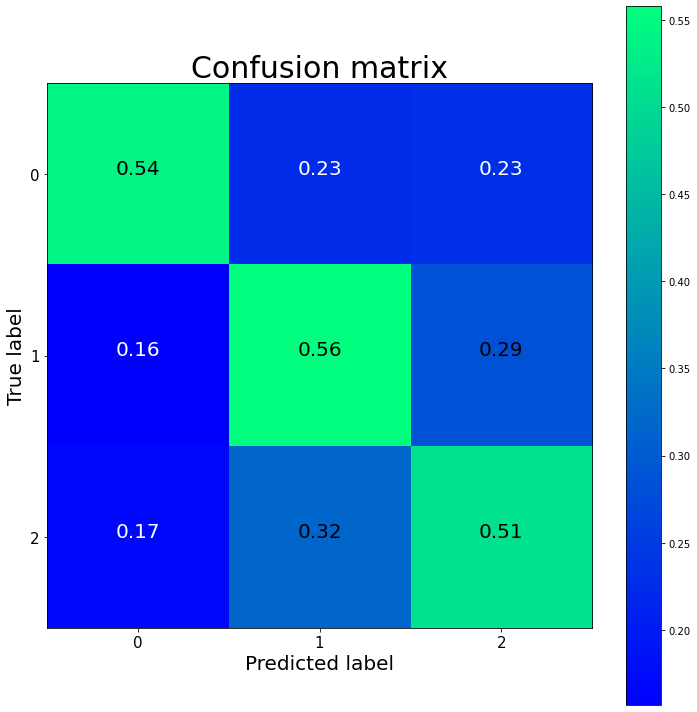

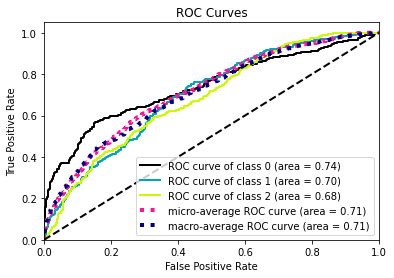

In [252]:
log_class.fit()

# Critère : Jours/année (en amalgamant les 3 colonnes de jour/mois/année)

In [334]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')


In [335]:
metric1='Number of days of teleworking if specified by WEEK                                    (0, 1, 2, 3, 4, 5, 6 IF THE NUMBER OF DAYS IS PER WEEK ; ELSE NaN)'
metric2='Number of days of teleworking if specified by MONTH                                     (0 TO 31 IF THE NUMBER OF DAYS IS PER MONTH ; ELSE NaN)'
metric3='Number of days of teleworking if specified by YEAR                                                                           (0 TO 365 IF THE NUMBER OF DAYS IS PER YEAR ; IF PER TRIMESTER/SEMESTER CONVERT THE NUMBER AND PUT IN THIS COLUMN ; ELSE NaN)'

df_0 = df.copy()

for met in [metric1,metric2,metric3] :
    df_0.loc[df_0[met].isnull(),met]=0

df_0[metric1] = df_0[metric1]*51
df_0[metric2] = df_0[metric2]*12
df_0['Nombre de jours par année'] = df_0[[metric1,metric2,metric3]].max(axis=1)
df = df_0

metric = 'Nombre de jours par année'
df = df[['contenu',metric]]
df.loc[df[metric].isnull(),metric]=0


df = df.dropna()
# def crop_content(content) :
#     n = min(10_000,len(content))
#     return content[:n]
# df['contenu']= df['contenu'].apply(crop_content)

C:\Users\wawa_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [338]:
# df.loc[df[metric].between(0.1,7),metric]=1
df.loc[df[metric].between(0.1,100),metric]=1
df.loc[df[metric]>100,metric]=2

In [339]:
df[metric]= df[metric].astype(int)

In [340]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [341]:
features = pd.DataFrame(embeddings_desc)

In [342]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [343]:
X_train_over, y_train_over = process_data(X_train,y_train,strategy='oversampling')

In [345]:
log_class = hyper_model(model_name = 'logistic_class',
                        X_train = X_train_over,
                        y_train = y_train_over,
                        X_test = X_test,
                        y_test = y_test,
                        classes=[0,1,2])  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    6.2s remaining:    4.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.3s finished


*** Global Metrics ***
accuracy = 0.5591666666666667 
 precision = 0.5636204484315533 
 recall = 0.5591666666666667 
 f1 = 0.5591209206071999
*** Per Class Metrics ***
accuracy = 0.5591666666666667 
 precision = [0.564      0.50627615 0.61016949] 
 recall = [0.66197183 0.5462754  0.52941176] 
 f1 = [0.60907127 0.52551574 0.56692913]


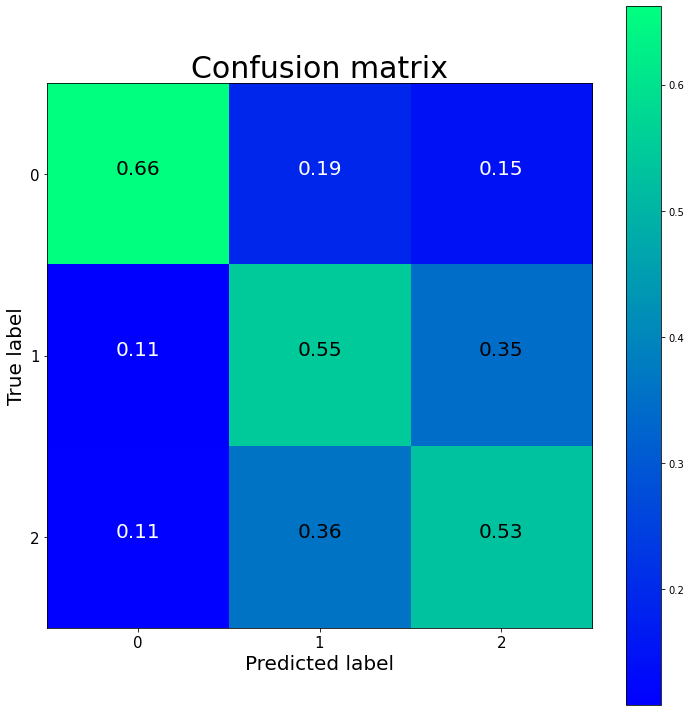

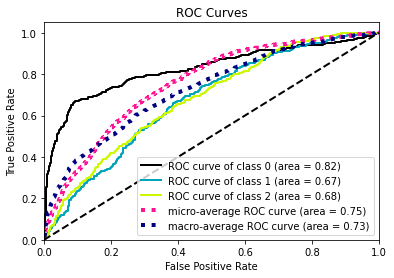

In [346]:
log_class.fit()

# Critère : Formation manager

In [347]:
import pandas as pd
df = pd.read_excel('grid_for_machine_learning.xlsx')

In [348]:
df.columns
metric = 'Training managers to remote management is scheduled (0=NO, 1=YES)'
df[metric].unique()
df.loc[df[metric].isnull(),metric]=0

df_0 = df
df = df[['contenu',metric]]
df = df.dropna()
# def crop_content(content) :
#     n = min(10_000,len(content))
#     return content[:n]
# df['contenu']= df['contenu'].apply(crop_content)

In [349]:
embeddings_desc = get_word2vec_embeddings(word2vec, df['contenu'].apply(tokenizer.tokenize))

In [350]:
features = pd.DataFrame(embeddings_desc)

In [351]:
X_train, X_test, y_train, y_test = train_test_split(features, df[metric], 
                                                                    test_size=0.3, random_state=42)

In [352]:
log_class = hyper_model(model_name = 'logistic_class',
                        X_train = X_train,
                        y_train = y_train,
                        X_test = X_test,
                        y_test = y_test)  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.6s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


*** Global Metrics ***
accuracy = 0.6533333333333333 
 precision = 0.7605243417720186 
 recall = 0.6533333333333333 
 f1 = 0.6838699288348656
*** Per Class Metrics ***
accuracy = 0.6533333333333333 
 precision = [0.87447109 0.33401222] 
 recall = [0.65469905 0.64822134] 
 f1 = [0.74879227 0.44086022]


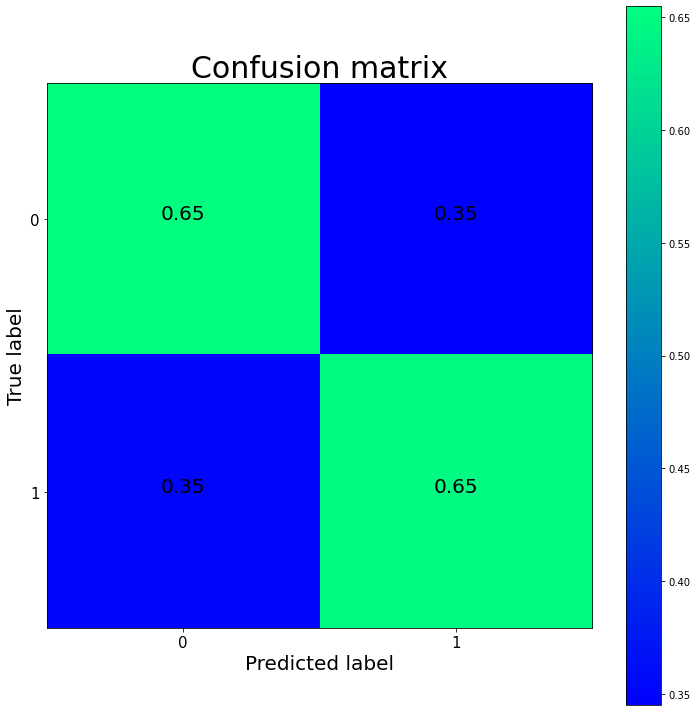

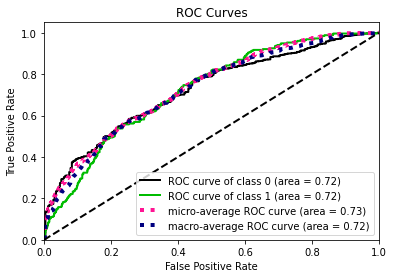

In [353]:
log_class.fit()